<a href="https://www.cognitiveclass.ai"><img src = "https://cognitiveclass.ai/wp-content/themes/bdu3.0/static/images/cc-logo.png" align = left></a>

<br>
<br>

--------------------
# Search for Extra Terrestrial Intelligence (SETI)
###  SETI Signal Classification on PowerAI with Single GPU
<hr>
<br>

### Introduction
In this notebook, we will use the famous [SETI Dataset](https://github.com/setiQuest/ML4SETI/) to build a convolutional neural network (CNN) able to perform signal classification. The CNN will determine, with some associated error, what type of signal is presented.

### Project overview
Each night, using the Allen Telescope Array (ATA) in northern California, the SETI Institute scans the sky at various radio frequencies, observing star systems with known exoplanets, searching for faint but persistent signals. The current signal detection system is programmed to search only for particular kinds of signals: narrow-band carrier waves. However, the detection system sometimes triggers on signals that are not narrow-band signals (with unknown efficiency) and are also not explicitly-known radio frequency interference (RFI). Various categories of these kinds of events have been observed in the past.

Our goal is to classify these accurately in real-time. This may allow the signal detection system to make better observational decisions, increase the efficiency of the nightly scans, and allow for explicit detection of these other signal types.

For more information refer to [SETI hackathon page](https://github.com/setiQuest/ML4SETI/).

### Performance
Convolutional neural networks involve a lot of matrix and vector multiplications that can be parallelized. GPUs can improve performance, because GPUs were designed to handle these operations in parallel!

### GPU vs. CPU
A single core CPU takes a matrix operation in serial, one element at a time, but a single GPU could have hundreds or thousands of cores, while a CPU typically has no more than a few cores.

### How to use GPUs with TensorFlow?
It is important to notice that if both CPU and GPU are available on the machine that you are running the notebook, and if a TensorFlow operation has both CPU and GPU implementations, the GPU devices will be given priority when the operation is assigned to a device.

In our case, as we are running this notebook on [IBM PowerAI](http://cocl.us/SETI-NIMBIX-PowerAI), you may have access to multiple GPUs, but lets use one of the GPUs in this notebook, for the sake of simplicity.

> Note: If you are running the free trial, you would expect to have zero GPUs. This notebook will work, but the training will be slow.

In [1]:
import sys
sys.path.insert(0, "/opt/DL/tensorflow/lib/python2.7/site-packages/")
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import time
import os
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from six.moves import urllib
import tarfile
import numpy as np
from PIL import Image
import math
import datetime
%matplotlib inline

### Set the parameters

In [2]:
### Set your working space here. Use this folder to save intermediate results.
dataset_name = 'SETI_ds_64x128'
data_dir = "tmp/SETI1_data/"
train_dir = 'tmp/SETI1_train/'
log_dir = train_dir + '1GPU_4'
# check point directory
chk_directory = train_dir + '/save1/'
checkpoint_path = chk_directory + 'model.ckpt'

### Create the necessary folders

In [3]:
if os.path.exists(data_dir) is False:
    os.makedirs(data_dir)
print data_dir
print os.popen("ls -lrt "+ data_dir).read()
if os.path.exists(train_dir) is False:
    os.makedirs(train_dir)
print train_dir

tmp/SETI1_data/
total 22001
drwxr-xr-x 1 nimbix nimbix 22522184 Nov  2  2017 SETI_ds_64x128
-rw-r--r-- 1 nimbix nimbix 22528713 Dec  1 01:23 qz33lcio9ip2j8qi2atxqs62gn3bnu2s.gz

tmp/SETI1_train/


### Import the dataset reader
The signals have been converted into spectogram images and stored as 4 files.
The following cell will download and import python code to help us decode the binary files, and read the SETI dataset.

In [4]:
!wget -q --output-document  SETI.zip  https://ibm.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
!unzip -o SETI.zip
import SETI

Archive:  SETI.zip
  inflating: SETI.py                 
  inflating: __MACOSX/._SETI.py      


### Download data
The following cell downloads and extracts the dataset.

In [5]:
def maybe_download_and_extract():
    DATA_URL =  'https://ibm.box.com/shared/static/qz33lcio9ip2j8qi2atxqs62gn3bnu2s.gz'
    dest_directory = data_dir
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        # print 'No zip file exists in ', filepath
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' % (filename, float(count * block_size) / float(total_size) * 100.0))
        sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)

    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    extracted_dir_path = os.path.join(dest_directory, dataset_name)
    if not os.path.exists(extracted_dir_path):
        print 'Extracting to', extracted_dir_path
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)
maybe_download_and_extract()

('Successfully downloaded', 'qz33lcio9ip2j8qi2atxqs62gn3bnu2s.gz', 22528713, 'bytes.')


### Load data SETI

In [6]:
ds_directory = data_dir + dataset_name
dataset = SETI.read_data_sets(ds_directory, one_hot=True, validation_size=0)
dataset.train.images.shape

Extracting tmp/SETI1_data/SETI_ds_64x128/train-images-idx3-ubyte.gz
Extracting tmp/SETI1_data/SETI_ds_64x128/train-labels-idx1-ubyte.gz
Extracting tmp/SETI1_data/SETI_ds_64x128/test-images-idx3-ubyte.gz
Extracting tmp/SETI1_data/SETI_ds_64x128/test-labels-idx1-ubyte.gz


(3200, 8192)

### Understanding the imported data

The imported data can be divided as follows:

- Training (dataset.train) >>  Use the given dataset with inputs and related outputs for training of NN. In our case, if you give an image that you know represents "class1", this set will tell the neural network that we expect "class1" as the output.  
        - 694 signals (images)
        - dataset.train.images for inputs
        - dataset.train.labels for outputs
  
  
- Test (mnist.test) >> The model does not have access to this information prior to the test phase. It is used to evaluate the performance and accuracy of the model against "real life situations". No further optimization beyond this point.  
        - 10,000 data points
        - dataset.test.images for inputs
        - dataset.test.labels for outputs
        
        
#### Labels
- Each image (spectrum of signal) in the dataset has been labeled from 1 to 4, representing:
    - squiggle
    - narrowband
    - noise
    - narrowbanddrd

## Network parameters

In [7]:
# Parameters
decay_rate=0.96
decay_steps=500
learning_rate = 0.005
training_epochs = 50
batch_size = 128
display_step = 1

n_classes = 4 # number of possible classifications for the problem
dropout = 0.60 # Dropout, probability to keep units

height = 64 # height of the image in pixels 
width = 128 # width of the image in pixels 
n_input = width * height # number of pixels in one image 


### Inputs

It's a best practice to create placeholders before variable assignments when using TensorFlow. Here we'll create placeholders for inputs ("x") and outputs ("y_").   

__Placeholder 'x':__ represents the "space" allocated input or the images. 
       * Each input has 8192 pixels distributed by a 64 width x 128 height matrix.
       * The 'shape' argument defines the tensor size by its dimensions.
       * 1st dimension = None. Indicates that the batch size can be of any size.
       * 2nd dimension = 8192. Indicates the number of pixels on a single flattened spectogram image.
      
__Placeholder 'y_':__ represents the final output or the labels.
       * 4 possible classes (0,1,2,3).
       * The 'shape' argument defines the tensor size by its dimensions.
       * 1st dimension = None. Indicates that the batch size can be of any size.
       * 2nd dimension = 4. Indicates the number of targets/outcomes.

__dtype for both placeholders:__ If you are not sure, use tf.float32. The limitation here is that the later presented softmax function only accepts float32 or float64 dtypes. For more dtypes, check TensorFlow's documentation <a href="https://www.tensorflow.org/versions/r0.9/api_docs/python/framework.html#tensor-types">here</a>

In [8]:
x  = tf.placeholder(tf.float32, shape=[None, n_input], name = 'x')
y_ = tf.placeholder(tf.float32, shape=[None, n_classes], name = 'y_')

The input image is a 64 pixels by 128 pixels, 1 channel (grayscale). In this case, the first dimension is the __batch number__ of the image and can be of any size (so we set it to -1). The second and third dimensions are width and height. The last one is the image channels.

In [9]:
x_image = tf.reshape(x, [-1,height,width,1]) 

### Convolutional neural networks (CNNs)

Convolutional neural networks (CNNs) are a type of feed-forward neural network, consisting of multiple layers of neurons that have learnable weights and biases. Each neuron in a layer that receives some input, processes it, and optionally follows it with non-linearity. The network has multiple layers such as convolution, max pool, drop out and fully connected layers. In each layer, small neurons process portions of the input image. The outputs of these collections are then tiled, so that their input regions overlap, to obtain a higher-resolution representation of the original image. This is repeated for every such layer. The important point here is: CNNs are able to break the complex patterns down into a series of simpler patterns, through multiple layers.

### CNN architecture
Now we are going to use a Deep Neural Network. 

Architecture of our network is:
    
- [Input] >>>> (batch_size, 64, 128, 1)  
- [Convolutional layer 1]  >>>> (batch_size, 64, 128, 32)
- [ReLU 1]  >>>> (batch_size, 64, 128, 32)
- [Max pooling 1] >>>> (batch_size, 32, 64, 32)
- [Convolutional layer 2]  >>>> (batch_size, 32, 64, 64)
- [ReLU 2]  >>>> (batch_size, 32, 64, 64)
- [Max pooling 2]  >>>> (batch_size, 8, 16, 64) 
- [fully connected layer 1] >>>> (batch_size, 1024)
- [ReLU]  >>>> (batch_size, 1024)
- [Drop out]  >>>> (batch_size, 1024)
- [Readout layer] >>>> (batch_size, 1024)


#### Convolutional Layer 1
We define a kernel here. The size of the filter/kernel is 5x5;  Input channels is 1 (greyscale);  and we need 32 different feature maps (here, 32 feature maps means 32 different filters are applied on each image. So, the output of the convolution layer would be 64x128x32). In this step, we create a filter / kernel tensor of shape `[filter_height, filter_width, in_channels, out_channels]`.

- To create a convolutional layer, we use __tf.nn.conv2d__. It computes a 2-D convolution given 4-D input and filter tensors.
- The convolutional layer slides the "kernel window" across the input tensor. As the input tensor has 4 dimensions:  [batch, height, width, channels], then the convolution operates on a 2D window on the height and width dimensions. __strides__ determines how much the window shifts in each of the dimensions. As the first and last dimensions are related to batch and channels, we set the stride to 1. But for second and third dimension, we could set other values, e.g. [1, 2, 2, 1]
- __max pooling__ is a form of non-linear down-sampling. It partitions the input image into a set of rectangles and, and then finds the maximum value for that region. Let's use __tf.nn.max_pool__ function to perform max pooling. 

In [10]:
with tf.variable_scope('layer1') as scope:
    W_conv1 = tf.get_variable( initializer= tf.truncated_normal([5, 5, 1, 32], stddev=0.1), name= 'w1')
    b_conv1 = tf.get_variable(initializer=tf.constant(0.1, shape=[32]), name='b1') # need 32 biases for 32 outputs
    convolve1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME', name='convolv1') + b_conv1
    h_conv1 = tf.nn.relu(convolve1, name='relu1')
    conv1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1') # max_pool_2x2

#### Convolutional Layer 2
We apply the convolution again in this layer. Lets look at the second layer kernel:  
- Filter/kernel: 5x5x32
- Input channels: 32 (from the 1st Conv layer, we had 32 feature maps), so we use 64 output feature maps  

In [11]:
with tf.variable_scope('layer2') as scope:
    W_conv2 = tf.get_variable(initializer=tf.truncated_normal([5, 5, 32, 64], stddev=0.1), name= 'w2')
    b_conv2 = tf.get_variable(initializer=tf.constant(0.1, shape=[64]),  name= 'b2') #need 64 biases for 64 outputs
    convolve2= tf.nn.conv2d(conv1, W_conv2, strides=[1, 1, 1, 1], padding='SAME', name='convolv2')+ b_conv2
    h_conv2 = tf.nn.relu(convolve2, name='relu2')
    conv2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 4, 4, 1], padding='SAME', name='pool2') #max_pool_2x2

#### Fully Connected Layer

You need a fully connected layer to use the Softmax and create the probabilities in the end. Fully connected layers take the high-level filtered images from the previous layer, that is all 64 metrics, and converts them to a flat array.

So, the matrix (8x16)x64 will be converted to a matrix of size (1x1024).

In [12]:
dim = conv2.get_shape().as_list()
dims = dim[1]*dim[2]*dim[3]
nodes1 = 1024
with tf.variable_scope('FullyCon1') as scope:
    prv_layer_matrix = tf.reshape(conv2, [-1, dims], name='rshaped_inp')
    W_fc1 = tf.get_variable(initializer= tf.truncated_normal([dims, nodes1], stddev=0.1), name='W_FC1')
    b_fc1 = tf.get_variable(initializer= tf.constant(0.1, shape=[nodes1]), name='b_FC1') # need 1024 biases for 1024 outputs
    h_fcl1  = tf.matmul(prv_layer_matrix, W_fc1) + b_fc1
    fc_layer1 = tf.nn.relu(h_fcl1, name='relu_FC1') 

#### Droupout 1
This is a phase where the network "forgets" some features. At each training step in a mini-batch, some units get switched off randomly so that they will not interact with the network. That is, its weights cannot be updated, nor affect the learning of the other network nodes. This can be very useful for very large neural networks to prevent overfitting.

In [13]:
keep_prob = tf.placeholder(tf.float32, name= 'keep_prob')
layer_drop1 = tf.nn.dropout(fc_layer1, keep_prob, name='dropout')

#### Readout Layer
In the last layer, CNN takes the high-level filtered images and translates them into votes using softmax. __softmax__ allows us to interpret the outputs of __fcl4__ as probabilities. So, __y_conv__ is a tensor of probabilities.
Input channels in this layer is 1024 (neurons from the 3rd layer) pixels, and output features are 4 classes. 

In [14]:
with tf.variable_scope('ReadoutLayer') as scope:
    W_fc = tf.get_variable(initializer = tf.truncated_normal([nodes1, n_classes], stddev=0.1), name ='W_FC2') #1024 neurons
    b_fc = tf.get_variable(initializer =tf.constant(0.1, shape=[n_classes]), name = 'b_FC2') # 10 possibilities for classes [0,1,2,3]
    fc = tf.matmul(layer_drop1, W_fc) + b_fc
    y_CNN= tf.nn.softmax(fc, name = 'softmax_linear')

#### Loss function
We need to compare our output, layer4 tensor, with ground truth for all mini_batch. We can use __cross entropy__ to see how bad our CNN is working - to measure the error at a softmax layer. __softmax_cross_entropy_with_logits__ 
computes softmax cross entropy between logits and labels, and __reduce_mean__ computes the mean of all elements in the tensor.

In [15]:
with tf.name_scope('cross_entropy'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_CNN, labels=y_))
    tf.summary.scalar('cross_entropy', cross_entropy)

#### Training
It is obvious that we want to minimize the error of our network which is calculated by the cross_entropy metric. To solve the problem, we have to compute gradients for the loss (which is minimizing the cross-entropy) and apply gradients to variables. This will be done by an optimizer: GradientDescent. 

In [16]:
# Create a variable to track the global step.
global_step = tf.Variable(0, trainable=False)

# create learning_decay
lr = tf.train.exponential_decay( learning_rate,
                                 global_step,
                                 decay_steps,
                                 decay_rate, staircase=True )
tf.summary.scalar('learning_rate', lr)

<tf.Tensor 'learning_rate:0' shape=() dtype=string>

In [17]:
# Use the optimizer to apply the gradients that minimize the loss
# (and also increment the global step counter) as a single training step.

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(lr)
    train_op = optimizer.minimize(cross_entropy, global_step=global_step)

#### Evaluation
Do you want to know how many of the cases in a mini-batch have been classified correctly? Let's count them.

In [18]:
with tf.name_scope('accuracy_all'):
    pred_lb = tf.argmax(y_CNN,1)
    true_lb = tf.argmax(y_,1)
    correct_prediction = tf.equal(pred_lb,true_lb )
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

In [19]:
# Calculate accuracy for test images
def evaluate():
    with tf.variable_scope(tf.get_variable_scope()):
        num_iter = int(math.ceil(dataset.test.num_examples / batch_size))
        true_count = 0  # Counts the number of correct predictions.
        total_sample_count = num_iter * batch_size
        step = 0
        while step < num_iter:
            x_batch, y_batch = dataset.test.next_batch(batch_size)
            predictions = sess.run([correct_prediction], feed_dict={x: x_batch, y_: y_batch, keep_prob: 1.})
            true_count += np.sum(predictions)
            step += 1

        precision = true_count*1.0 / total_sample_count
        tf.summary.scalar('precision', precision)
        return precision

### Create checkpoint directory

In [20]:
directory = os.path.dirname(chk_directory)
try:
    os.stat(directory)
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    print ckpt
except:
    os.mkdir(directory) 

model_checkpoint_path: "tmp/SETI1_train//save1/model.ckpt-720"
all_model_checkpoint_paths: "tmp/SETI1_train//save1/model.ckpt-0"
all_model_checkpoint_paths: "tmp/SETI1_train//save1/model.ckpt-720"



<div class="alert alert-success alertsuccess" style="margin-top: 20px">
<font size = 3><strong>*You can run this cell if you REALLY have time to wait, or you are running it using PowerAI   </strong></font>
<br>

<b> What is PowerAI?  </b>

Running deep learning programs usually needs a high performance platform. PowerAI speeds up deep learning and AI. Built on IBM's Power Systems, PowerAI is a scalable software platform that accelerates deep learning and AI with blazing performance for individual users or enterprises. The PowerAI platform supports popular machine learning libraries and dependencies including Tensorflow, Caffe, Torch, and Theano. You can download a [free version of PowerAI](https://cocl.us/DX0108EN-PowerAI).

<br>
__Notice:__ If you are running this notebook on PowerAI, it will automatically run on a GPU, otherwise it will use a CPU. Also, you can change the number of epochs to gain a higher accuracy.
</div>

## Training

In [21]:
num_examples = dataset.train.num_examples
total_batch = int(num_examples / batch_size)
print 'Training dataset size:',num_examples, ' Signals'
print 'Testing dataset size:',dataset.test.num_examples, ' Signals'
print 'Total epochs:', training_epochs
print 'Total steps:', training_epochs * total_batch
print 'Batch size:', batch_size
print 'Total batchs per epoch:',total_batch
print str(datetime.datetime.now())
# Initializing the variables
init = tf.global_variables_initializer()
loss_values = []
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)

merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(log_dir, sess.graph)
    
X_test = dataset.test.images
y_test = dataset.test.labels
sess.run(init)
saver = tf.train.Saver(tf.global_variables())

# load previously trained model if appilcable
ckpt = tf.train.get_checkpoint_state(chk_directory)
if ckpt:
    print ("loading model: ",ckpt.model_checkpoint_path)
    # saver.restore(sess, ckpt.model_checkpoint_path)

# Training cycle
tr_start = time.time()
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    total_batch = int(num_examples / batch_size)

    # Loop over all batches
    start = time.time()
    for step in range(total_batch):
        x_batch, y_batch = dataset.train.next_batch(batch_size ,shuffle=True)
        b_start_time = time.time()
        loss, acc = sess.run([cross_entropy, accuracy], feed_dict={x: x_batch,y_: y_batch,keep_prob: 1.})
        sess.run(train_op,feed_dict={x: x_batch, y_: y_batch, keep_prob: dropout})
        b_end_time = time.time() - b_start_time
        avg_loss += loss / total_batch
        avg_train_acc += acc / total_batch
        
        
    # save model every x epochs
    if epoch >= 0 and epoch % 50 == 0:
        # Save model
        # print ("model saved to {}".format(checkpoint_path))
        saver.save(sess, checkpoint_path, global_step = epoch)
        
        
    ## Display model every 1 epochs
    if epoch >= 0 and epoch % display_step == 0:
        end = time.time()
        plr = sess.run(lr)
        loss_values.append(avg_loss) 
        test_acc  = evaluate()
        print("Epoch:"+ '%04d' % (epoch+1) + \
            ", Ep_time=" + "{:.2f}".format(end - start) + \
            ", lr=" + "{:.9f}".format(plr) + \
            ", avg_cost=" + "{:.3f}".format(avg_loss) + \
            ", Train_Acc=" + "{:.2f}".format(avg_train_acc) + \
            ", Test_Acc=" + "{:.2f}".format(test_acc) + 
            ", Batch (sec)=" + "{:.3f}".format(b_end_time)  ) 
        
    # Summarize model every x epochs
    if epoch >= 0 and epoch % 1 == 0:   
        summary= sess.run(merged,feed_dict={x: x_batch,y_: y_batch,keep_prob: 1.})
        train_writer.add_summary(summary, epoch)
print("Wall Time:","{:.1f}".format((time.time() - tr_start)/60.0, "Min"))        
print("Optimization Finished!")
print ("model saved to {}".format(checkpoint_path))
saver.save(sess, checkpoint_path, global_step = (epoch+1)*step)
train_writer.close()

Training dataset size: 3200  Signals
Testing dataset size: 800  Signals
Total epochs: 50
Total steps: 1250
Batch size: 128
Total batchs per epoch: 25
2018-12-01 02:23:22.755197
('loading model: ', u'tmp/SETI1_train//save1/model.ckpt-720')
Epoch:0001, Ep_time=87.81, lr=0.005000000, avg_cost=1.492, Train_Acc=0.25, Test_Acc=0.25, Batch (sec)=3.427
Epoch:0002, Ep_time=85.62, lr=0.005000000, avg_cost=1.455, Train_Acc=0.26, Test_Acc=0.26, Batch (sec)=3.413
Epoch:0003, Ep_time=85.30, lr=0.005000000, avg_cost=1.413, Train_Acc=0.27, Test_Acc=0.24, Batch (sec)=3.460
Epoch:0004, Ep_time=85.40, lr=0.005000000, avg_cost=1.407, Train_Acc=0.30, Test_Acc=0.25, Batch (sec)=3.415
Epoch:0005, Ep_time=85.42, lr=0.005000000, avg_cost=1.432, Train_Acc=0.28, Test_Acc=0.26, Batch (sec)=3.411
Epoch:0006, Ep_time=85.29, lr=0.005000000, avg_cost=1.382, Train_Acc=0.35, Test_Acc=0.27, Batch (sec)=3.393
Epoch:0007, Ep_time=85.21, lr=0.005000000, avg_cost=1.390, Train_Acc=0.31, Test_Acc=0.28, Batch (sec)=3.406
Epoch

In [22]:
# Find the labels of test set
y_pred_lb = sess.run(tf.argmax(y_CNN,1), feed_dict={x: X_test, y_: y_test, keep_prob: 1.})
y_pred = sess.run(y_CNN, feed_dict={x: X_test, y_: y_test, keep_prob: 1.})

# lets save kernels
kernels_l1 = sess.run(tf.reshape(tf.transpose(W_conv1, perm=[2, 3, 0, 1]),[32,-1]))
kernels_l2 = sess.run(tf.reshape(tf.transpose(W_conv2, perm=[2, 3, 0, 1]),[32*64,-1]))

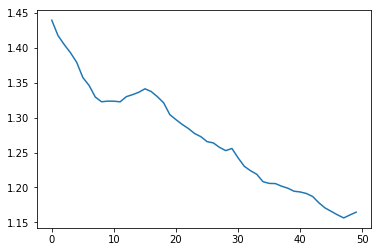

In [23]:
plt.plot([np.mean(loss_values[i:i+5]) for i in range(len(loss_values))])
plt.show()

## Evaluation

Accuracy depends on the number of epochs that you set in the parameters part.

In [24]:
y_ = np.argmax(y_test,1) # ground truth
print metrics.classification_report(y_true= y_, y_pred= y_pred_lb)
print metrics.confusion_matrix(y_true= y_, y_pred= y_pred_lb)
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true= y_, y_pred= y_pred_lb) )
print("Log Loss: %0.6f" % metrics.log_loss(y_true= y_, y_pred= y_pred) )

             precision    recall  f1-score   support

          0       0.38      0.98      0.55       200
          1       0.53      0.18      0.27       200
          2       0.67      0.03      0.06       200
          3       1.00      1.00      1.00       200

avg / total       0.64      0.55      0.47       800

[[197   2   1   0]
 [161  37   2   0]
 [163  31   6   0]
 [  0   0   0 200]]
Classification accuracy: 0.550000
Log Loss: 0.789618


### Viz
Do you want to look at all the filters? Let's use __utils__ to visualize them.

In [25]:
!wget --output-document utils1.py http://deeplearning.net/tutorial/code/utils.py
import utils1
from utils1 import tile_raster_images

--2018-12-01 03:39:06--  http://deeplearning.net/tutorial/code/utils.py
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5097 (5.0K) [text/plain]
Saving to: 'utils1.py'

100%[======================================>] 5,097       --.-K/s   in 0s      

2018-12-01 03:39:07 (505 MB/s) - 'utils1.py' saved [5097/5097]



Here you can plot the 32 filters in the first convolutional layer.

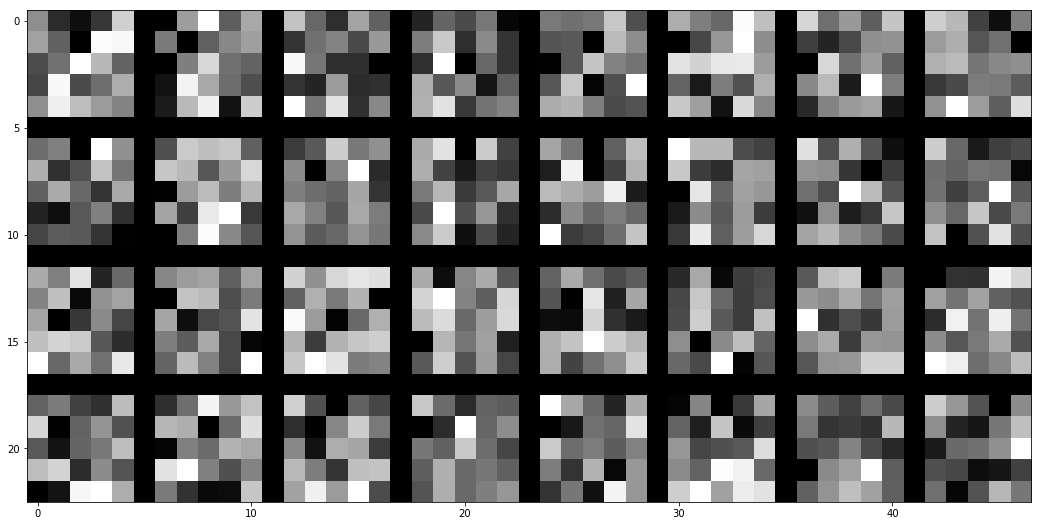

In [26]:
image = Image.fromarray(tile_raster_images(kernels_l1, img_shape=(5, 5) ,tile_shape=(4, 8), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

Also, you can plot and take a look at some filters from the second convolutional layers:

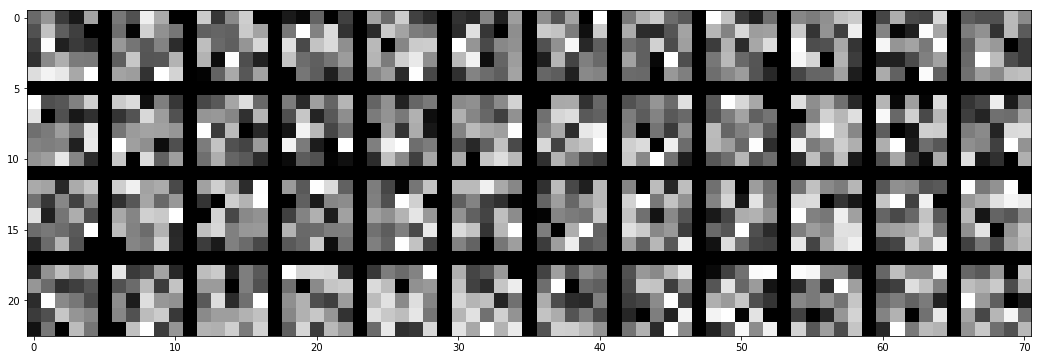

In [27]:
image = Image.fromarray(tile_raster_images(kernels_l2, img_shape=(5, 5) ,tile_shape=(4, 12), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

To understand better, let's apply one of these filters on a sample signal (spectogram image). First, let's plot a sample spectogram:

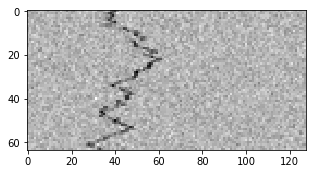

In [28]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
sampleimage1 = X_test[3]
plt.imshow(np.reshape(sampleimage1,[64,128]), cmap="gray")

Now we apply different filters on them, and plot the result:

Instructions for updating:
Please use tf.global_variables instead.
loading model:  tmp/SETI1_train//save1/model.ckpt-1200
INFO:tensorflow:Restoring parameters from tmp/SETI1_train//save1/model.ckpt-1200


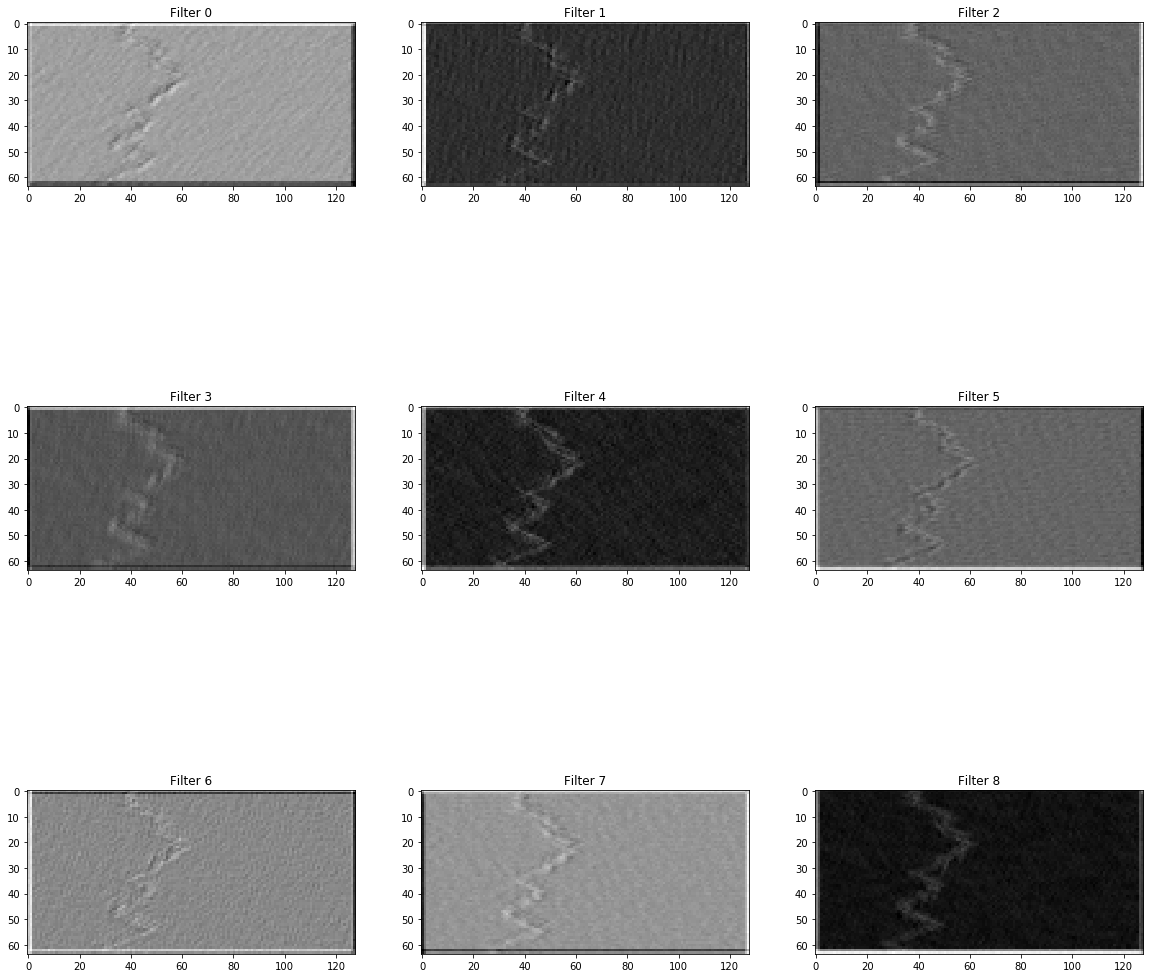

In [29]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    saver = tf.train.Saver(tf.all_variables())
    
    # load previously trained model if appilcable
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    if ckpt:
        print "loading model: ",ckpt.model_checkpoint_path
        saver.restore(sess, ckpt.model_checkpoint_path)
    ActivatedUnits1 = sess.run(convolve1,feed_dict={x:np.reshape(sampleimage1,[1,64*128],order='F'),keep_prob:1.0})
    plt.figure(1, figsize=(20,20))
    n_columns = 3
    n_rows = 3
    for i in range(9):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(ActivatedUnits1[0,:,:,i], interpolation="nearest", cmap="gray")

### Benchmark:
- SETI_multi_gpu_train.py achieves ~72% accuracy after 3k epochs of data (75K steps).
- Speed: With batch_size 128.  
- __Notice:__ The model is not optimized to reach its highest accuracy. You can achieve better results by tuning the parameters.

<table border="1" style="box-sizing: border-box; border-spacing: 30px; background-color: transparent; color: #333333; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-size: 12px;">
<tbody style="box-sizing: border-box;">
<tr style="box-sizing: border-box;">
<td style="box-sizing: border-box; padding: 3px; text-align:left;"><span style="box-sizing: border-box; font-weight: bold;">CPU Architecture</span></td>
<td style="box-sizing: border-box; padding: 3px; text-align:left;"><span style="box-sizing: border-box; font-weight: bold;">CPU cores&nbsp;</span></td>
<td style="box-sizing: border-box; padding: 3px; text-align:left;"><span style="box-sizing: border-box; font-weight: bold;">Memory&nbsp;</span></td>
<td style="box-sizing: border-box; padding: 3px; text-align:left;"><span style="box-sizing: border-box; font-weight: bold;">GPU&nbsp;</span></td>
<td style="box-sizing: border-box; padding: 3px; text-align:left;"><span style="box-sizing: border-box; font-weight: bold;">Step time (sec/batch)&nbsp;</span></td>
<td style="box-sizing: border-box; padding: 3px; text-align:left;"><span style="box-sizing: border-box; font-weight: bold;">&nbsp;Accuracy</span></td>
</tr>
<tr style="box-sizing: border-box;">
<td style="box-sizing: border-box; padding: 3px; text-align:left;">POWER8</td>
<td style="box-sizing: border-box; padding: 3px; text-align:center;">40</td>
<td style="box-sizing: border-box; padding: 3px; text-align:center;">256 GB</td>
<td style="box-sizing: border-box; padding: 3px; text-align:left;">1 x Tesla K80</td>
<td style="box-sizing: border-box; padding: 3px; text-align:center;">~0.127 </td>
<td style="box-sizing: border-box; padding: 3px; text-align:left;">~72% at 75K steps  (3 hours)</td>
</tr>
<tr style="box-sizing: border-box;">
<td style="box-sizing: border-box; padding: 3px; text-align:left;" >POWER8</td>
<td style="box-sizing: border-box; padding: 3px; text-align:center;">32</td>
<td style="box-sizing: border-box; padding: 3px; text-align:center;">128 GB</td>
<td style="box-sizing: border-box; padding: 3px; text-align:left;">1 x Tesla P100 w/NVLink np8g4</td>
<td style="box-sizing: border-box; padding: 3px; text-align:center;">~0.035 </td>
<td style="box-sizing: border-box; padding: 3px; text-align:left;">~72% at 75K steps  (1 hour)</td>
</tr>


</tbody>
</table>




## Want to learn more?

[Deep Learning with TensorFlow](http://cocl.us/SETI-NIMBIX-ML0102EN) is a free course in __cognitiveclass.ia__ where you can learn TensorFlow and Deep Learning together.

Running deep learning programs usually needs a high performance platform. PowerAI speeds up deep learning and AI. Built on IBM's Power Systems, PowerAI is a scalable software platform that accelerates deep learning and AI with blazing performance for individual users or enterprises. The PowerAI platform supports popular machine learning libraries and dependencies including Tensorflow, Caffe, Torch, and Theano. You can download a [free version of PowerAI](http://cocl.us/SETI-NIMBIX-PowerAI).

### Authors

<div class="teacher-image" style="    float: left;
    width: 115px;
    height: 115px;
    margin-right: 10px;
    margin-bottom: 10px;
    border: 1px solid #CCC;
    padding: 3px;
    border-radius: 3px;
    text-align: center;"><img class="alignnone wp-image-2258 " src="https://ibm.box.com/shared/static/tyd41rlrnmfrrk78jx521eb73fljwvv0.jpg" alt="Saeed Aghabozorgi" width="178" height="178" /></div>
#### Saeed Aghabozorgi

[Saeed Aghabozorgi](https://ca.linkedin.com/in/saeedaghabozorgi), PhD is Sr. Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>


